# Generating the Dataset for the Whole City

## Problem
The City Economist's data only covered the parcels in San Francisco which were affected by the Family Zoning plan, so in order to do Fantasy Zoning across the entire city, we need to backwards-engineer the relevant inputs for the model for the parcels that are not in the City Economist's dataset.

## Datasets Used
- City Economist's data (https://github.com/dbroockman/bluesky-2025/tree/main) (private repo)
- active-and-retired-parcels.csv https://data.sfgov.org/Geographic-Locations-and-Boundaries/Parcels-Active-and-Retired/acdm-wktn/about_data, last udpated Dec 25, 2025
- land-use.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-Land-Use-2023/fdfd-xptc/about_data) last updated Apr 4, 2024
- height-and-bulk-districts.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/Zoning-Map-Height-and-Bulk-Districts/h9wh-cg3m/about_data) last updated Dec 25, 2025
- zoning-districts.csv (https://data.sfgov.org/Geographic-Locations-and-Boundaries/Zoning-Map-Zoning-Districts/3i4a-hu95/about_data) Last updated Dec 25, 2025
- historic-districts.csv https://data.sfgov.org/Geographic-Locations-and-Boundaries/Historic-Districts/63x5-g3m4/about_data Last updated Dec 25, 2025

## Misc
- City Economist's report (https://drive.google.com/file/d/1Ua4admMow-OPSwTEqYe8JdGOYh5ne8Ot/view?usp=sharing), particularly pages 35-37 with the mapping of zoning code to zp_* attribute

## Data Quality Investigation Notes

### Issue 1: Missing Parcel Data

276 FZP parcels are missing from the final model output. Root causes:

1. **207 P-zoned parcels**: Intentionally removed via `remove_public_parcels()` because they're in public-parcels.geojson (parks, government buildings).

2. **47 parcels in public-parcels.geojson**: Various zones (RH-1, RH-2, C-3-G, etc.) that were previously identified as public.

3. **17 Presidio parcels**: Removed by `remove_presidio_parcels()` because the Presidio is under federal jurisdiction.

4. **3 parcels with mapblklot != blklot**: Join mismatch between FZP BlockLot and SF parcel mapblklot.

### Issue 2: SDB and Zoning_DR Variables

From Egan's City Economist report:

- **SDB_2016_5Plus**: Dummy indicating eligibility for State Density Bonus (since 2016, for 5+ unit sites)
- **SDB_2016_5Plus_EnvFull**: Interaction term = `SDB_2016_5Plus × Env_1000_Area_Height`
- **Zoning_DR_EnvFull**: Interaction term = `Zoning_DR × Env_1000_Area_Height` (for density-restricted zones)

**Pattern found for SDB_2016_5Plus = 1:**
- Almost exclusively in RTO (Residential Transit-Oriented) and NCT (Neighborhood Commercial Transit) zones
- Combined with Env >= 9 gives 99.6% accuracy on FZP data
- **Proposed heuristic**: `SDB = 1 if (zoning contains RTO/NCT/WMUG) AND (Env >= 9)`

**Zoning_DR_EnvFull = 0 for all parcels:**
- This appears intentional in FZP data since the rezoning removes density restrictions
- Keeping as 0 for now

### Issue 3: East-Side Parcels Causing 10x Expected Units Spike

After adding 60,281 east-side parcels, expected units jumped from 10k-18k to 97k-120k.

**Root cause: ~100 anomaly parcels contributing 86,000+ expected units:**

| Zone Type | Parcels | Expected Units | Example |
|-----------|---------|----------------|----------|
| TI-OS (Treasure Island Open Space) | 30 | 34,764 | 12.5M sq ft open space parcel |
| M-2 (Industrial) | 54 | 20,555 | Port/factory sites |
| PDR-2 | 925 | 4,046 | Production/Distribution |
| Large RH-1(D) (>100k sqft) | ~20 | 9,500+ | Olympic Club, SF Golf Club, schools |

**Solution: Remove non-housing parcels** (implemented in `remove_non_housing_parcels()`):
- Industrial zones: M-1, M-2
- PDR zones: PDR-1-B, PDR-1-D, PDR-1-G, PDR-2
- Treasure Island zones: TI-OS, TI-R, TI-MU
- Public zones: P
- Large RH-1(D) parcels: Area > 100k sq ft (golf courses, schools, parks)


## Load the Data

Load all source data files once into memory. These raw dataframes should be referenced but never modified.

In [1]:
import pandas as pd
import geopandas as gpd
from collections import Counter
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np

from transforms import (
    deduplicate_by_mapblklot,
    fill_missing_addresses,
    merge_model_data,
    remove_public_parcels,
    NON_HOUSING_EXACT_ZONES, NON_HOUSING_PREFIX_PATTERNS,
    LARGE_PARCEL_AREA_THRESHOLD,
    identify_non_housing_parcels,
    remove_non_housing_parcels,
    remove_shipyard_parcels,
    fill_missing_area,
    remove_presidio_parcels,
    fill_missing_districts,
    fill_res_dummy,
    fill_building_sqft,
    fill_zoning_from_spatial_join,
    fill_zp_columns,
    fill_height_from_spatial_join,
    remove_open_space_parcels,
    fill_envelope,
    SDB_ZONE_PATTERNS,
    SDB_ENVELOPE_THRESHOLD,
    SDB_HEIGHT_CAP,
    fill_sdb_columns,
    compute_sdb_qualification,
    compute_historic_from_districts,
    fill_historic_columns,
    calculate_expected_units,
    fill_transit_distance,
)

raw_parcels_df = pd.read_csv('active-and-retired-parcels.csv', dtype=str)
print(f'raw_parcels_df (active-and-retired-parcels.csv): {len(raw_parcels_df):,} rows')

raw_model_df = pd.read_csv('input/parcels-w-fzp-model-data.csv', dtype=str)
print(f'raw_model_df (parcels-w-fzp-model-data.csv): {len(raw_model_df):,} rows')

raw_public_parcels_df = gpd.read_file('../public/data/public-parcels.geojson')
print(f'raw_public_parcels_df (public-parcels.geojson): {len(raw_public_parcels_df):,} rows')

raw_land_use_df = pd.read_csv('input/land-use.csv', dtype=str)
print(f'raw_land_use_df (land-use.csv): {len(raw_land_use_df):,} rows')

raw_zoning_district_df = pd.read_csv('input/zoning-district.csv', dtype=str)
raw_zoning_district_gdf = gpd.GeoDataFrame(
    raw_zoning_district_df,
    geometry=gpd.GeoSeries.from_wkt(raw_zoning_district_df['the_geom']),
    crs='EPSG:4326'
)
print(f'raw_zoning_district_gdf (zoning-district.csv): {len(raw_zoning_district_gdf):,} rows')

parcels_df = raw_parcels_df.copy()

raw_parcels_df (active-and-retired-parcels.csv): 236,823 rows
raw_model_df (parcels-w-fzp-model-data.csv): 92,722 rows


raw_public_parcels_df (public-parcels.geojson): 2,379 rows


raw_land_use_df (land-use.csv): 154,476 rows
raw_zoning_district_gdf (zoning-district.csv): 1,652 rows


## Clean Up Parcel Data

### Deduplicate by Mapblklot

For each mapblklot, we keep the first row as "canonical" and aggregate all associated blklots into a `blklots` column.

In [2]:
mapblklot_to_blocklots = raw_parcels_df.groupby('mapblklot')['blklot'].apply(set).to_dict()

multi_blocklot_count = sum(1 for blklots in mapblklot_to_blocklots.values() if len(blklots) > 1)
total_mapblklots = len(mapblklot_to_blocklots)

print(f'Total unique mapblklots: {total_mapblklots:,}')
print(f'Mapblklots with multiple blocklots: {multi_blocklot_count:,} ({multi_blocklot_count/total_mapblklots*100:.1f}%)')
print(f'Mapblklots with single blocklot: {total_mapblklots - multi_blocklot_count:,} ({(total_mapblklots - multi_blocklot_count)/total_mapblklots*100:.1f}%)')

distribution = Counter(len(blklots) for blklots in mapblklot_to_blocklots.values())
six_plus = sum(num for count, num in distribution.items() if count >= 6)

print(f'\nDistribution of blocklots per mapblklot:')
for count in range(1, 6):
    print(f'  {count} blocklot(s): {distribution[count]:,} mapblklots')
print(f'  6+ blocklot(s): {six_plus:,} mapblklots')

Total unique mapblklots: 163,167
Mapblklots with multiple blocklots: 9,462 (5.8%)
Mapblklots with single blocklot: 153,705 (94.2%)

Distribution of blocklots per mapblklot:
  1 blocklot(s): 153,705 mapblklots
  2 blocklot(s): 4,959 mapblklots
  3 blocklot(s): 1,829 mapblklots
  4 blocklot(s): 884 mapblklots
  5 blocklot(s): 155 mapblklots
  6+ blocklot(s): 1,635 mapblklots


In [3]:
print(f'Before deduplication: {len(parcels_df):,} rows')

parcels_df = deduplicate_by_mapblklot(parcels_df)

print(f'After deduplication: {len(parcels_df):,} rows')

Before deduplication: 236,823 rows


After deduplication: 163,167 rows


### Fill Missing Addresses from Land Use Data

Fill in missing address fields (from_address_num, street_name, street_type) from land-use.csv.

In [4]:
missing_before = (parcels_df['from_address_num'].isna() | (parcels_df['from_address_num'] == '')).sum()
print(f'Parcels missing address before: {missing_before:,}')

parcels_df = fill_missing_addresses(parcels_df, raw_land_use_df)

missing_after = (parcels_df['from_address_num'].isna() | (parcels_df['from_address_num'] == '')).sum()
print(f'Parcels missing address after: {missing_after:,}')
print(f'Filled: {missing_before - missing_after:,} addresses')

Parcels missing address before: 11,110


Parcels missing address after: 10,943
Filled: 167 addresses


### Merge Model Data into Parcels Data, Remove Inactive Parcels

Merge `model_df` data into `parcels_df` by matching BlockLot to any blklot in the blklots column.

For some reason, model_df has parcels that are no longer active. So we keep parcels that have model data OR are active.

In [5]:
print(f'Before merge: {len(parcels_df):,} parcels')

parcels_df = merge_model_data(parcels_df, raw_model_df, raw_parcels_df)

print(f'After merge (keeping parcels with model data or active status): {len(parcels_df):,} parcels')

Before merge: 163,167 parcels


After merge (keeping parcels with model data or active status): 155,126 parcels


### Sanity Check: Look at Map of Parcels with Model Data

Red = has model data, White = no model data

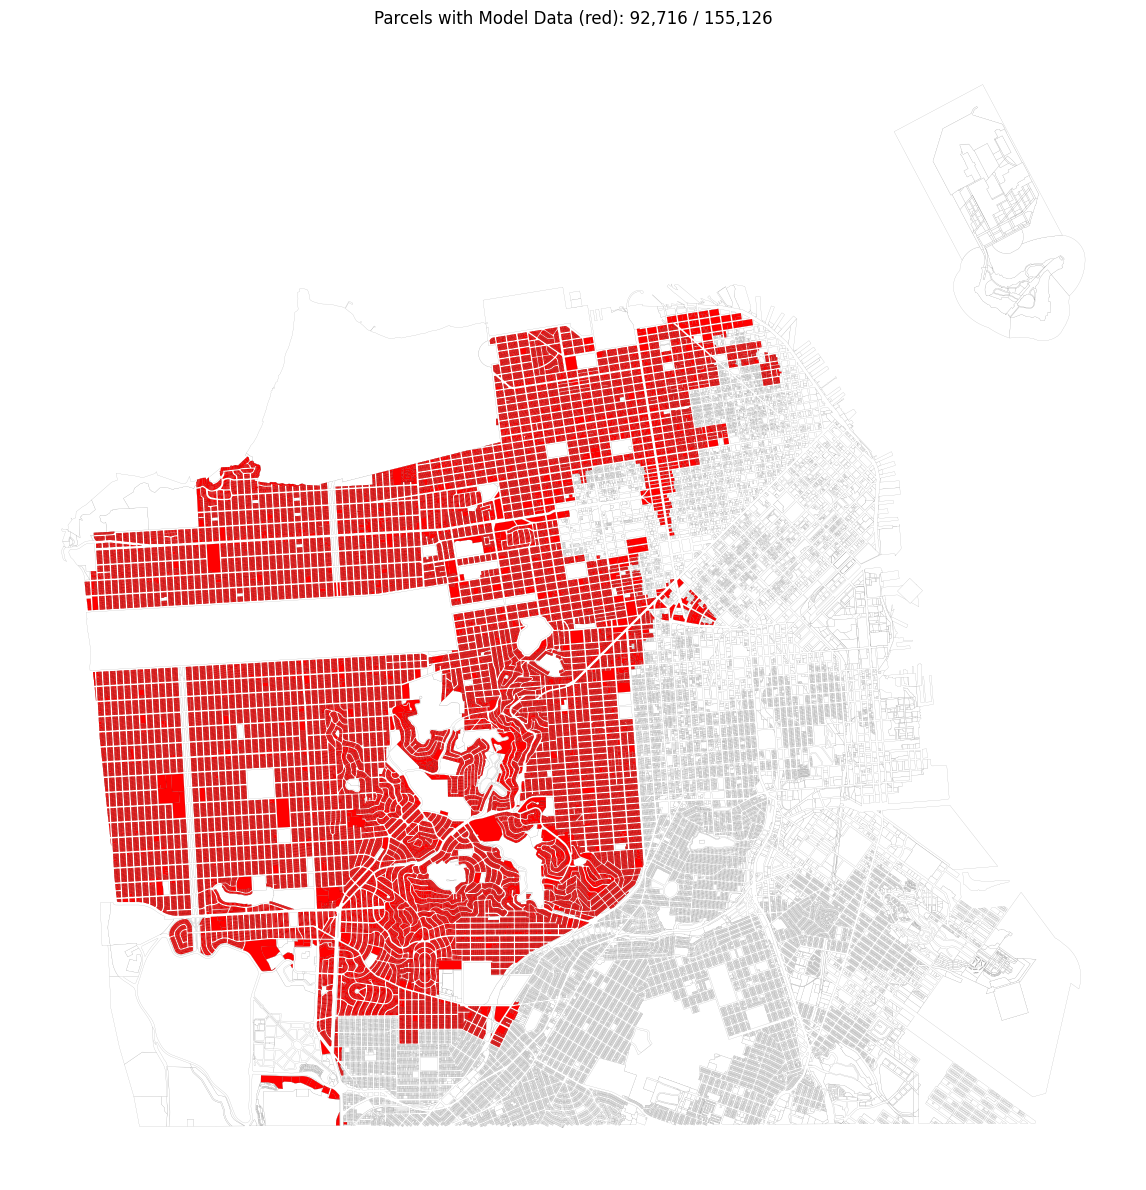

In [6]:
geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

model_mapblklots = set(raw_model_df['BlockLot'])
geom_df['has_model'] = geom_df['mapblklot'].isin(model_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['has_model']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['has_model']].plot(ax=ax, color='red', edgecolor='darkred', linewidth=0.1)
ax.set_title(f'Parcels with Model Data (red): {geom_df["has_model"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Inspect Public Parcels

Green = public parcel (will be removed), White = non-public

NOTE: The list of public parcels was arbitrarily determined by me previously. I think it was based on some judgment and using the P zoning designation. TODO I could do it more systematically and document it here. 

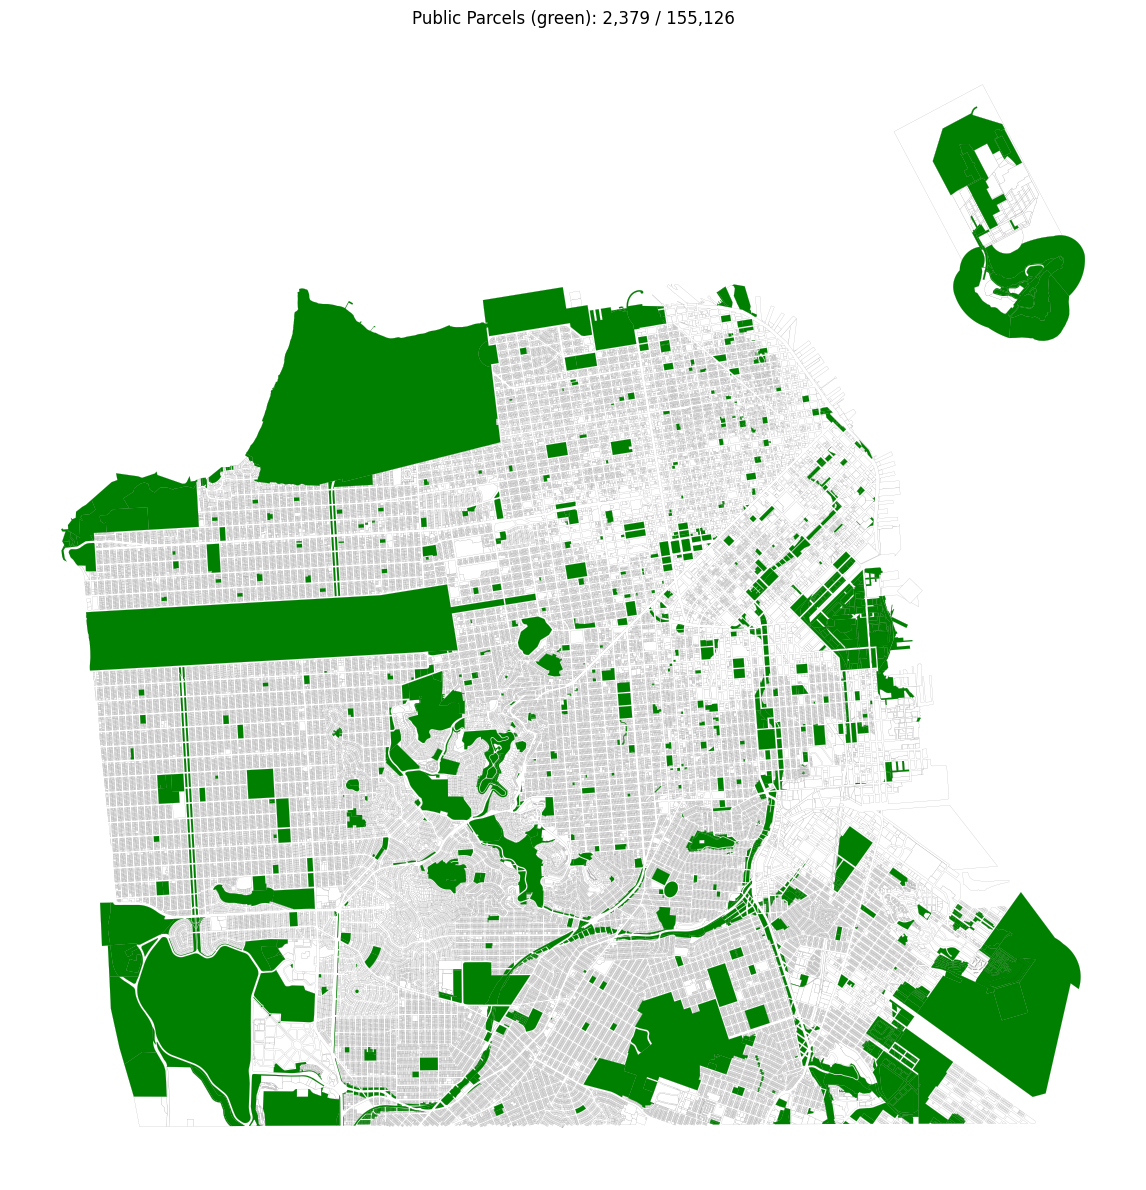

In [7]:
public_mapblklots = set(raw_public_parcels_df['mapblklot'])

geom_df['is_public'] = geom_df['mapblklot'].isin(public_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['is_public']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['is_public']].plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=0.1)
ax.set_title(f'Public Parcels (green): {geom_df["is_public"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Remove Public Parcels

Remove parcels that are in public-parcels.geojson (parks, government buildings, etc.)

In [8]:
print(f'Before removing public parcels: {len(parcels_df):,}')

parcels_df = remove_public_parcels(parcels_df, raw_public_parcels_df)

print(f'After removing public parcels: {len(parcels_df):,}')

Before removing public parcels: 155,126
After removing public parcels: 152,747


### Double Check: Public parcels removed from main parcels

Red = has model data, White = no model data (after removing public parcels)

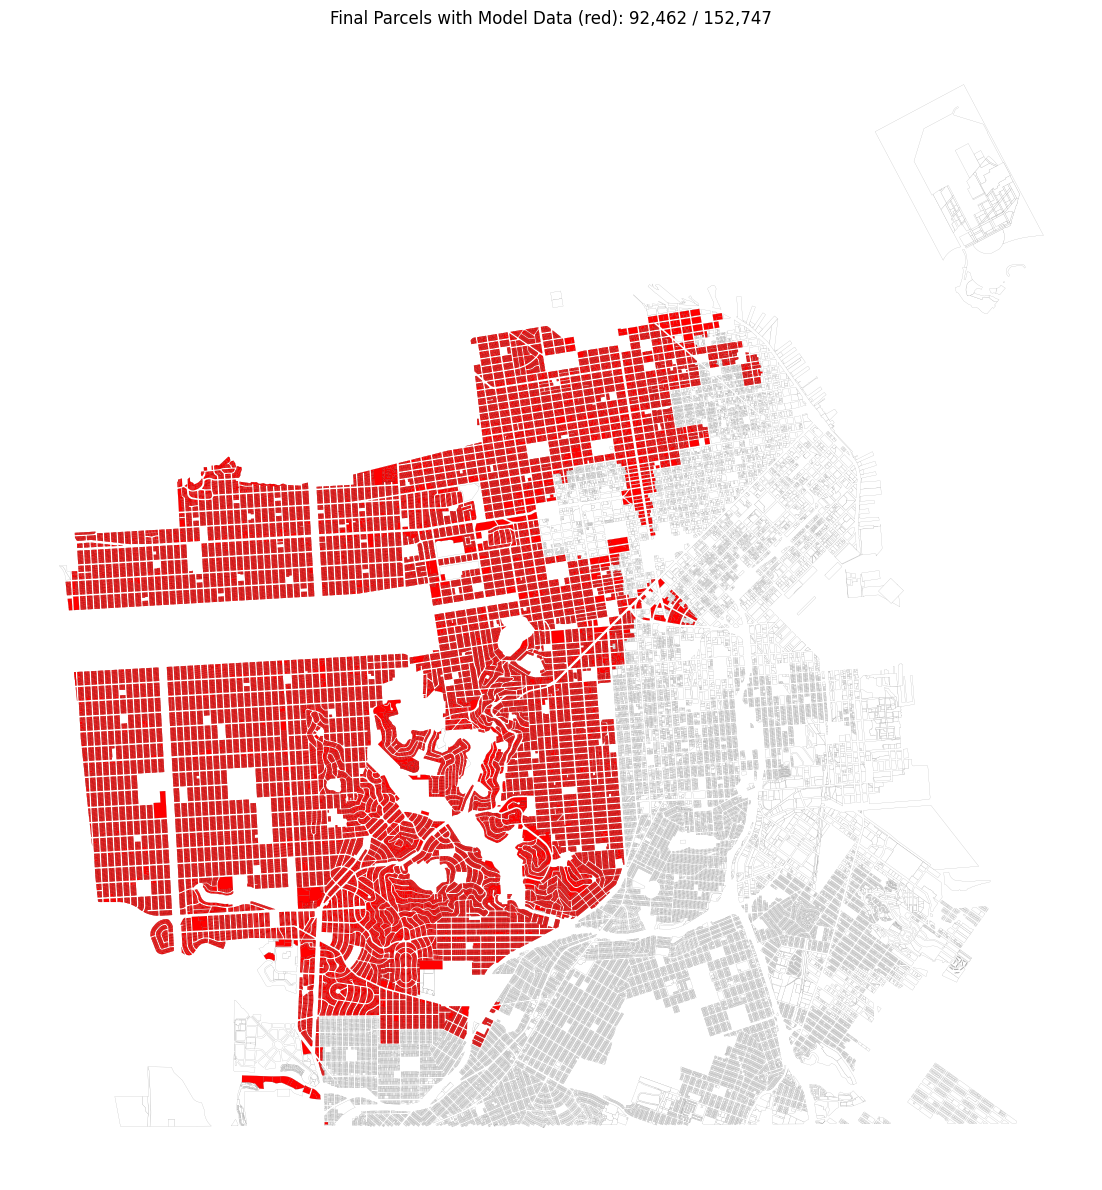

In [9]:
geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

model_mapblklots = set(raw_model_df['BlockLot'])
geom_df['has_model'] = geom_df['mapblklot'].isin(model_mapblklots)

fig, ax = plt.subplots(figsize=(12, 12))
geom_df[~geom_df['has_model']].plot(ax=ax, color='white', edgecolor='gray', linewidth=0.1)
geom_df[geom_df['has_model']].plot(ax=ax, color='red', edgecolor='darkred', linewidth=0.1)
ax.set_title(f'Final Parcels with Model Data (red): {geom_df["has_model"].sum():,} / {len(geom_df):,}')
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Calculate Area from Shape Geometry

Compare calculated area from WKT geometry against the existing Shape_Area_SqFt from model data to verify that the method I have in mind is correct/good.

In [10]:
test_area_df = parcels_df[parcels_df['Shape_Area_SqFt'].notna()].copy()
print(f'Parcels with existing Shape_Area_SqFt: {len(test_area_df):,}')

test_area_df['geometry'] = test_area_df['shape'].apply(wkt.loads)
test_area_gdf = gpd.GeoDataFrame(test_area_df, geometry='geometry', crs='EPSG:4326')

test_area_gdf = test_area_gdf.to_crs('EPSG:2227')
test_area_gdf['calculated_area_sqft'] = test_area_gdf.geometry.area

test_area_gdf['existing_area'] = test_area_gdf['Shape_Area_SqFt'].str.replace(',', '').astype(float)
test_area_gdf['area_diff'] = test_area_gdf['calculated_area_sqft'] - test_area_gdf['existing_area']
test_area_gdf['area_pct_diff'] = (test_area_gdf['area_diff'] / test_area_gdf['existing_area']) * 100

print(f'\nArea comparison statistics:')
print(f'Mean absolute difference: {test_area_gdf["area_diff"].abs().mean():,.1f} sqft')
print(f'Median absolute difference: {test_area_gdf["area_diff"].abs().median():,.1f} sqft')
print(f'Mean percentage difference: {test_area_gdf["area_pct_diff"].mean():.2f}%')
print(f'Median percentage difference: {test_area_gdf["area_pct_diff"].median():.2f}%')
print(f'\nPercentile distribution of absolute percentage difference:')
for p in [50, 90, 95, 99]:
    print(f'  {p}th percentile: {np.percentile(test_area_gdf["area_pct_diff"].abs(), p):.2f}%')

Parcels with existing Shape_Area_SqFt: 92,463



Area comparison statistics:
Mean absolute difference: 5.4 sqft
Median absolute difference: 0.2 sqft
Mean percentage difference: inf%
Median percentage difference: 0.00%

Percentile distribution of absolute percentage difference:
  50th percentile: 0.01%
  90th percentile: 0.02%
  95th percentile: 0.02%
  99th percentile: 0.03%


### Calculate Area for Parcels Missing Shape_Area_SqFt
Looks good! For parcels without model data, calculate area from the WKT geometry using EPSG:2227 (California State Plane Zone 3, feet).

In [11]:
missing_before = parcels_df['Shape_Area_SqFt'].isna().sum()
print(f'Parcels missing Shape_Area_SqFt before: {missing_before:,}')

parcels_df = fill_missing_area(parcels_df)

print(f'Parcels with Shape_Area_SqFt after: {parcels_df["Shape_Area_SqFt"].notna().sum():,}')
print(f'Parcels with Area_1000 after: {parcels_df["Area_1000"].notna().sum():,}')

Parcels missing Shape_Area_SqFt before: 60,284


Parcels with Shape_Area_SqFt after: 152,747
Parcels with Area_1000 after: 152,747


## Set up DIST_* variable

### Planning District Distribution

Count of parcels by planning district.

In [12]:
district_counts = parcels_df['planning_district'].value_counts(dropna=False).sort_index()
print(f'Planning district distribution ({len(parcels_df):,} parcels):\n')
for district, count in district_counts.items():
    label = district if pd.notna(district) else '(null)'
    print(f'  {label}: {count:,}')

Planning district distribution (152,747 parcels):

  Bernal Heights: 6,629
  Buena Vista: 5,116
  Central: 12,446
  Downtown: 2,267
  Ingleside: 16,531
  Inner Sunset: 12,000
  Marina: 6,390
  Mission: 7,193
  Northeast: 6,259
  Outer Sunset: 20,795
  Presidio: 16
  Richmond: 17,033
  South Bayshore: 9,134
  South Central: 21,146
  South of Market: 4,783
  Western Addition: 5,009


### Remove Presidio Parcels

Remove parcels in the Presidio planning district (federal land, not subject to SF zoning).

In [13]:
print(f'Before removing Presidio: {len(parcels_df):,}')

parcels_df = remove_presidio_parcels(parcels_df)

print(f'After removing Presidio: {len(parcels_df):,}')

Before removing Presidio: 152,747
After removing Presidio: 152,731


### Compare DIST_* Columns to Planning District

Verify that the mapping from `planning_district` to DIST_* columns matches the existing model data.

In [14]:
planning_to_dist = {
    'South Bayshore': 'DIST_SBayshore',
    'Bernal Heights': 'DIST_BernalHts',
    'South Central': 'DIST_Scentral',
    'Central': 'DIST_Central',
    'Buena Vista': 'DIST_BuenaVista',
    'Northeast': 'DIST_Northeast',
    'Western Addition': 'DIST_WestAddition',
    'South of Market': 'DIST_SOMA',
    'Inner Sunset': 'DIST_InnerSunset',
    'Richmond': 'DIST_Richmond',
    'Ingleside': 'DIST_Ingleside',
    'Outer Sunset': 'DIST_OuterSunset',
    'Marina': 'DIST_Marina',
    'Mission': 'DIST_Mission',
}

dist_cols = [c for c in parcels_df.columns if c.startswith('DIST_')]
has_model = parcels_df[dist_cols[0]].notna()
model_parcels = parcels_df[has_model]

print(f'Parcels with existing DIST_* data: {len(model_parcels):,}')

total_discrepancies = 0
discrepancies_by_col = {}

for district, col in planning_to_dist.items():
    expected = (model_parcels['planning_district'] == district).astype(int)
    actual = model_parcels[col].astype(int)
    diff = (expected != actual).sum()
    if diff > 0:
        discrepancies_by_col[col] = diff
        total_discrepancies += diff

print(f'Total discrepancies: {total_discrepancies:,}')
if discrepancies_by_col:
    print(f'\nDiscrepancies by column:')
    for col, count in sorted(discrepancies_by_col.items(), key=lambda x: -x[1]):
        print(f'  {col}: {count:,}')
else:
    print('Mapping is correct!')

Parcels with existing DIST_* data: 92,447


Total discrepancies: 0
Mapping is correct!


### Fill DIST_* Columns for Parcels Missing Model Data

For parcels without model data, set DIST_* columns based on planning_district.

In [15]:
dist_cols = [c for c in parcels_df.columns if c.startswith('DIST_')]
missing_before = parcels_df[dist_cols[0]].isna().sum()
print(f'Parcels missing DIST_* before: {missing_before:,}')

parcels_df = fill_missing_districts(parcels_df)

print(f'Parcels with DIST_* after: {parcels_df[dist_cols[0]].notna().sum():,}')

Parcels missing DIST_* before: 60,284


Parcels with DIST_* after: 152,731


### Sanity Check: Any row with all 0s should be in the "Downtown" planning neighborhood

In [16]:
dist_cols = [c for c in parcels_df.columns if c.startswith('DIST_')]
all_dist_zero = (parcels_df[dist_cols].astype(int).sum(axis=1) == 0)
print(f'Parcels with all DIST_* = 0: {all_dist_zero.sum():,}')

non_downtown = all_dist_zero & (parcels_df['planning_district'] != 'Downtown')
print(f'Parcels with all DIST_* = 0 but NOT Downtown: {non_downtown.sum():,}')

if non_downtown.sum() > 0:
    print(f'\nUnexpected planning districts:')
    print(parcels_df.loc[non_downtown, 'planning_district'].value_counts())
else:
    print('Check passed!')

Parcels with all DIST_* = 0: 2,267
Parcels with all DIST_* = 0 but NOT Downtown: 0
Check passed!


## Merge Land Use Data - Res_Dummy

test the hypothesis: Res_Dummy = 1 if ResUnits > 0

In [17]:
land_use_mapblklots = set(raw_land_use_df['mapblklot'])

blklot_to_mapblklot = raw_parcels_df.set_index('blklot')['mapblklot'].to_dict()
model_mapblklots = set(raw_model_df['BlockLot'].map(blklot_to_mapblklot).dropna())

print(f'Land use mapblklots: {len(land_use_mapblklots):,}')
print(f'Model mapblklots: {len(model_mapblklots):,}')
print(f'Overlap: {len(land_use_mapblklots & model_mapblklots):,}')

Land use mapblklots: 154,476


Model mapblklots: 92,717
Overlap: 92,715


In [18]:
test_df = parcels_df[parcels_df['Res_Dummy'].notna()][['mapblklot', 'Res_Dummy']].copy()
print(f'Parcels with Res_Dummy in model data: {len(test_df):,}')

land_use_subset = raw_land_use_df[['mapblklot', 'resunits']].copy()
land_use_subset['resunits_numeric'] = land_use_subset['resunits'].str.replace(',', '').astype(float)

test_df = test_df.merge(land_use_subset, on='mapblklot', how='inner')
print(f'Matched with land-use data: {len(test_df):,}')

test_df['Res_Dummy_int'] = test_df['Res_Dummy'].astype(int)
test_df['predicted_res_dummy'] = (test_df['resunits_numeric'] > 0).astype(int)

match = (test_df['Res_Dummy_int'] == test_df['predicted_res_dummy']).sum()
mismatch = len(test_df) - match

print(f'\nHypothesis: Res_Dummy = 1 if resunits > 0')
print(f'Match: {match:,} ({match/len(test_df)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(test_df)*100:.1f}%)')

if mismatch > 0:
    print(f'\nMismatch breakdown:')
    mismatch_df = test_df[test_df['Res_Dummy_int'] != test_df['predicted_res_dummy']]
    print(f'  Res_Dummy=1 but resunits=0: {((mismatch_df["Res_Dummy_int"] == 1) & (mismatch_df["resunits_numeric"] == 0)).sum():,}')
    print(f'  Res_Dummy=0 but resunits>0: {((mismatch_df["Res_Dummy_int"] == 0) & (mismatch_df["resunits_numeric"] > 0)).sum():,}')

Parcels with Res_Dummy in model data: 92,447
Matched with land-use data: 92,445

Hypothesis: Res_Dummy = 1 if resunits > 0
Match: 92,432 (100.0%)
Mismatch: 13 (0.0%)

Mismatch breakdown:
  Res_Dummy=1 but resunits=0: 0
  Res_Dummy=0 but resunits>0: 13


### Fill Res_Dummy and ResUnits for Parcels Missing Model Data

13 is not 0 but seems good enough so let's move forward with it.

In [19]:
missing_before = parcels_df['Res_Dummy'].isna().sum()
print(f'Parcels missing Res_Dummy before: {missing_before:,}')

parcels_df = fill_res_dummy(parcels_df, raw_land_use_df)

print(f'Parcels with Res_Dummy after: {parcels_df["Res_Dummy"].notna().sum():,}')
print(f'Parcels with Res_Units after: {parcels_df["Res_Units"].notna().sum():,}')

Parcels missing Res_Dummy before: 60,284


Parcels with Res_Dummy after: 152,731
Parcels with Res_Units after: 152,036


### TODO: Investigate the 720 missing Res_Units
Hypothesis 1: Mapblklots vs. blocklots. Try it using blocklots.

## Get existing building size

In [20]:
sqft_cols = ['visitor', 'pdr', 'retail', 'mips', 'med', 'cie', 'res']

land_use_sqft = raw_land_use_df[['mapblklot'] + sqft_cols].copy()
for col in sqft_cols:
    land_use_sqft[col] = land_use_sqft[col].str.replace(',', '').astype(float)

land_use_sqft['calculated_sqft'] = land_use_sqft[sqft_cols].sum(axis=1)

test_df = parcels_df[parcels_df['Tot_Existing_SqFt'].notna()][['mapblklot', 'Tot_Existing_SqFt']].copy()
test_df['existing_sqft'] = test_df['Tot_Existing_SqFt'].str.replace(',', '').astype(float)
test_df = test_df.merge(land_use_sqft[['mapblklot', 'calculated_sqft']], on='mapblklot', how='inner')

print(f'Parcels with existing Tot_Existing_SqFt: {len(test_df):,}')

test_df['diff'] = test_df['calculated_sqft'] - test_df['existing_sqft']
match = (test_df['diff'].abs() < 1).sum()
mismatch = len(test_df) - match

print(f'\nCalculated vs Tot_Existing_SqFt:')
print(f'Match: {match:,} ({match/len(test_df)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(test_df)*100:.1f}%)')

if mismatch > 0:
    print(f'\nMismatch statistics:')
    print(f'Mean diff: {test_df["diff"].mean():,.1f}')
    print(f'Median diff: {test_df["diff"].median():,.1f}')
    print(f'\nSample mismatches:')
    mismatch_df = test_df[test_df['diff'].abs() >= 1].sort_values('diff', key=abs, ascending=False)
    print(mismatch_df[['mapblklot', 'existing_sqft', 'calculated_sqft', 'diff']].head(10).to_string())

Parcels with existing Tot_Existing_SqFt: 92,442

Calculated vs Tot_Existing_SqFt:
Match: 64,685 (70.0%)
Mismatch: 27,757 (30.0%)

Mismatch statistics:
Mean diff: 269.5
Median diff: 0.0

Sample mismatches:
      mapblklot  existing_sqft  calculated_sqft      diff
15881   0695007      1015000.0          38805.0 -976195.0
69312   0671009       216909.0         913457.0  696548.0
27064   0628014       662281.0          94205.0 -568076.0
17244   3583011         3600.0         565784.0  562184.0
13578   0628013       127189.0         660227.0  533038.0
21662   1049070         1596.0         452285.0  450689.0
439     0451007       128000.0         521083.0  393083.0
87813   0606002         6690.0         385440.0  378750.0
183     0690017       200000.0         519223.0  319223.0
24225   1098050       384808.0          96067.0 -288741.0


In [21]:
sqft_cols = ['visitor', 'pdr', 'retail', 'mips', 'med', 'cie', 'res']

land_use_sqft = raw_land_use_df[['mapblklot'] + sqft_cols].copy()
for col in sqft_cols:
    land_use_sqft[col] = land_use_sqft[col].str.replace(',', '').astype(float)

test_df = parcels_df[parcels_df['Tot_Existing_SqFt'].notna()][['mapblklot', 'Tot_Existing_SqFt']].copy()
test_df['existing_sqft'] = test_df['Tot_Existing_SqFt'].str.replace(',', '').astype(float)
test_df = test_df.merge(land_use_sqft, on='mapblklot', how='inner')

test_df['calc_all'] = test_df[sqft_cols].sum(axis=1)
test_df['calc_res_only'] = test_df['res']
test_df['calc_res_retail_cie'] = test_df['res'] + test_df['retail'] + test_df['cie']

test_df['match_all'] = (test_df['calc_all'] - test_df['existing_sqft']).abs() < 1
test_df['match_res_only'] = (test_df['calc_res_only'] - test_df['existing_sqft']).abs() < 1
test_df['match_res_retail_cie'] = (test_df['calc_res_retail_cie'] - test_df['existing_sqft']).abs() < 1

print(f'Total parcels: {len(test_df):,}\n')
print(f'Match rates by formula:')
print(f'  All cols (visitor+pdr+retail+mips+med+cie+res): {test_df["match_all"].sum():,} ({test_df["match_all"].mean()*100:.1f}%)')
print(f'  res only: {test_df["match_res_only"].sum():,} ({test_df["match_res_only"].mean()*100:.1f}%)')
print(f'  res + retail + cie: {test_df["match_res_retail_cie"].sum():,} ({test_df["match_res_retail_cie"].mean()*100:.1f}%)')

mismatch_all = test_df[~test_df['match_all']]
match_all = test_df[test_df['match_all']]

print(f'\n--- Mismatch analysis (all cols formula) ---')
print(f'Mismatches: {len(mismatch_all):,}')

print(f'\nColumn value distributions (mean):')
print(f'{"Column":<12} {"Match":>12} {"Mismatch":>12}')
print('-' * 38)
for col in sqft_cols:
    print(f'{col:<12} {match_all[col].mean():>12,.1f} {mismatch_all[col].mean():>12,.1f}')

print(f'\nColumn non-zero rates:')
print(f'{"Column":<12} {"Match":>12} {"Mismatch":>12}')
print('-' * 38)
for col in sqft_cols:
    match_nz = (match_all[col] > 0).mean() * 100
    mismatch_nz = (mismatch_all[col] > 0).mean() * 100
    print(f'{col:<12} {match_nz:>11.1f}% {mismatch_nz:>11.1f}%')

print(f'\nFor mismatches, which single column matches existing_sqft?')
for col in sqft_cols:
    matches_col = ((mismatch_all[col] - mismatch_all['existing_sqft']).abs() < 1).sum()
    if matches_col > 0:
        print(f'  {col}: {matches_col:,}')

print(f'\nFor mismatches, which combo matches existing_sqft?')
combos = [
    ('res', ['res']),
    ('res+retail', ['res', 'retail']),
    ('res+cie', ['res', 'cie']),
    ('res+retail+cie', ['res', 'retail', 'cie']),
    ('res+retail+mips', ['res', 'retail', 'mips']),
]
for name, cols in combos:
    calc = mismatch_all[cols].sum(axis=1)
    matches = ((calc - mismatch_all['existing_sqft']).abs() < 1).sum()
    if matches > 0:
        print(f'  {name}: {matches:,}')

Total parcels: 92,442

Match rates by formula:
  All cols (visitor+pdr+retail+mips+med+cie+res): 64,685 (70.0%)
  res only: 77,981 (84.4%)
  res + retail + cie: 73,895 (79.9%)

--- Mismatch analysis (all cols formula) ---
Mismatches: 27,757

Column value distributions (mean):
Column              Match     Mismatch
--------------------------------------
visitor               0.8         45.3
pdr                   1.7        265.9
retail                0.7        751.0
mips                  0.9      1,400.5
med                   0.1        422.9
cie                   4.4        447.8
res               2,360.8      2,777.7

Column non-zero rates:
Column              Match     Mismatch
--------------------------------------
visitor              0.0%         0.5%
pdr                  0.0%         8.5%
retail               0.0%        16.3%
mips                 0.0%        36.7%
med                  0.0%         5.4%
cie                  0.0%         7.3%
res                 98.5%        76.

## Apply residential square feet to building size.
It appears that the best way to approximate what Egan did for this attribute is to simply take residential square footage. However, as demonstratd above, while it covers about 85% of all parcels, the remaining 15% do not match this. 

If you dig deeper, it is unclear where/how Egan is getting his numbers. A bunch of his parcels have 0 current building sq ft, even though the land use database says it does. Elsewhere the land use database says there is no square footage but Egan's data says it does. 

Very likely I am not looking at the correct data source. TODO: Figure out where Egan is getting this data. 

For now, though, this is good enough to continue on.

In [22]:
missing_before = parcels_df['Tot_Existing_SqFt'].isna().sum()
print(f'Parcels missing Tot_Existing_SqFt before: {missing_before:,}')

parcels_df = fill_building_sqft(parcels_df, raw_land_use_df)

print(f'Parcels with Tot_Existing_SqFt after: {parcels_df["Tot_Existing_SqFt"].notna().sum():,}')
print(f'Parcels with Bldg_SqFt_1000 after: {parcels_df["Bldg_SqFt_1000"].notna().sum():,}')

Parcels missing Tot_Existing_SqFt before: 60,287
Parcels with Tot_Existing_SqFt after: 152,039
Parcels with Bldg_SqFt_1000 after: 152,039


## Apply the right zoning code to each parcel missing the zoning code.
The FZP Planning Code attribute will determine which ZP_* attribute gets passed to the mode.

### Hypothesis 1: Use zoning_code from land-use.csv for Planning Code.

If we took the zoning_code attribute from land-use.csv and dumb applied it to FZP Planning code, this is the number of FZP Planning Codes that would have been correct (matched) vs. incorrect (mismatched).

In [23]:
model_parcels = parcels_df[parcels_df['FZP Planning Code'].notna()].copy()
print(f'Parcels with FZP Planning Code: {len(model_parcels):,}')

match = (model_parcels['zoning_code'] == model_parcels['FZP Planning Code']).sum()
mismatch = len(model_parcels) - match

print(f'\nzoning_code vs FZP Planning Code:')
print(f'Match: {match:,} ({match/len(model_parcels)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(model_parcels)*100:.1f}%)')

Parcels with FZP Planning Code: 92,447

zoning_code vs FZP Planning Code:
Match: 78,569 (85.0%)
Mismatch: 13,878 (15.0%)


In [24]:
mismatch_df = model_parcels[model_parcels['zoning_code'] != model_parcels['FZP Planning Code']].copy()
mismatch_df['pair'] = mismatch_df['zoning_code'] + ' -> ' + mismatch_df['FZP Planning Code']
pair_counts = mismatch_df['pair'].value_counts()

print(f'Mismatched pairs ({len(mismatch_df):,} total):\n')
print(pair_counts.to_string())

Mismatched pairs (13,878 total):

pair
RH-2 -> RTO-C                                3246
RH-1 -> RTO-C                                1626
RH-3 -> RTO-C                                1402
RTO -> RTO-1                                 1302
RM-1 -> RTO-C                                1291
RH-1(D) -> RTO-C                              541
NCD -> NCD-GEARY BOULEVARD                    389
RM-2 -> RTO-C                                 305
NCD -> NCD-POLK                               247
NCD -> NCD-INNER SUNSET                       244
NCD -> NCD-TARAVAL                            243
NCD -> NCD-UNION                              215
RM-3 -> RTO-C                                 207
NCT -> NCT-DIVISADERO                         179
NCD -> NCD-24TH-NOE-VALLEY                    162
NCD -> NCD-INNER CLEMENT                      161
NCT -> NCT-UPPER MARKET                       132
NCD -> NCD-OUTER CLEMENT                      118
NCD -> NCD-NORIEGA                            115
NCT -> NCT-

### Hypothesis 2 - zoning districts csv

Let's use a separate dataset called zoning districts.

In [25]:
model_parcels = parcels_df[parcels_df['FZP Planning Code'].notna()].copy()
print(f'Parcels with FZP Planning Code: {len(model_parcels):,}')

model_parcels['geometry'] = model_parcels['shape'].apply(wkt.loads)
model_gdf = gpd.GeoDataFrame(model_parcels, geometry='geometry', crs='EPSG:4326')

model_gdf_projected = model_gdf.to_crs('EPSG:2227')
model_gdf['centroid'] = model_gdf_projected.geometry.centroid.to_crs('EPSG:4326')

centroid_gdf = model_gdf.set_geometry('centroid')
joined = gpd.sjoin(centroid_gdf, raw_zoning_district_gdf[['geometry', 'zoning']], how='left', predicate='within')
joined = joined.rename(columns={'zoning': 'zoning_district_code'})

model_gdf['zoning_district_code'] = joined['zoning_district_code'].values

match = (model_gdf['zoning_district_code'] == model_gdf['FZP Planning Code']).sum()
no_zone_found = model_gdf['zoning_district_code'].isna().sum()
mismatch = len(model_gdf) - match - no_zone_found

print(f'\nzoning-district.csv vs FZP Planning Code:')
print(f'Match: {match:,} ({match/len(model_gdf)*100:.1f}%)')
print(f'Mismatch: {mismatch:,} ({mismatch/len(model_gdf)*100:.1f}%)')
print(f'No zone found (centroid outside all districts): {no_zone_found:,} ({no_zone_found/len(model_gdf)*100:.1f}%)')

Parcels with FZP Planning Code: 92,447



zoning-district.csv vs FZP Planning Code:
Match: 82,079 (88.8%)
Mismatch: 10,368 (11.2%)
No zone found (centroid outside all districts): 0 (0.0%)


In [26]:
mismatch_mask = (model_gdf['zoning_district_code'] != model_gdf['FZP Planning Code']) & model_gdf['zoning_district_code'].notna()
mismatch_gdf = model_gdf[mismatch_mask].copy()
mismatch_gdf['pair'] = mismatch_gdf['zoning_district_code'] + ' -> ' + mismatch_gdf['FZP Planning Code']
pair_counts = mismatch_gdf['pair'].value_counts()

print(f'Mismatched pairs ({len(mismatch_gdf):,} total):\n')
print(pair_counts.head(50).to_string())

Mismatched pairs (10,368 total):

pair
RH-2 -> RTO-C                       3247
RH-1 -> RTO-C                       1626
RH-3 -> RTO-C                       1403
RTO -> RTO-1                        1307
RM-1 -> RTO-C                       1295
RH-1(D) -> RTO-C                     542
RM-2 -> RTO-C                        310
RM-3 -> RTO-C                        210
RC-4 -> RTO-C                         50
RTO -> RTO-C                          41
RH-2 -> NC-1                          25
RH-2 -> NCD-GEARY BOULEVARD           21
RH-2 -> NCD-INNER SUNSET              19
RH-1 -> NC-1                          17
RH-1 -> NCD-NORIEGA                   15
RM-4 -> RTO-C                         11
RM-1 -> NCD-OUTER CLEMENT             11
RM-1 -> NCD-INNER CLEMENT             11
RM-1 -> NC-S                          10
RM-1 -> NCD-GEARY BOULEVARD            9
RH-2 -> NCD-OUTER CLEMENT              8
RH-2 -> NCT-GLEN PARK                  8
NCD-UPPER FILLMORE -> RTO-C            8
RH-2 -> NCD-OUTER 

### Apply Hypothesis 2
Approach #2 is slightly better. So let's go with that.
For parcels missing FZP Planning Code, use spatial join with zoning-district.csv to fill in the zoning code.

In [27]:
missing_before = parcels_df['FZP Planning Code'].isna().sum()
print(f'Parcels missing FZP Planning Code before: {missing_before:,}')

parcels_df = fill_zoning_from_spatial_join(parcels_df, raw_zoning_district_gdf)

print(f'Parcels with FZP Planning Code after: {parcels_df["FZP Planning Code"].notna().sum():,}')
print(f'Parcels without FZP Planning Code after: {parcels_df["FZP Planning Code"].isna().sum():,}')

Parcels missing FZP Planning Code before: 60,284


Parcels with FZP Planning Code after: 151,901
Parcels without FZP Planning Code after: 830


### Map FZP Planning Code to zp_* Attributes

Based on pages 35-37 of the Egan report, map each parcel's `FZP Planning Code` to the appropriate `zp_*` dummy variable. RH-1/RH-1(D) is the baseline (all zp_* = 0). For parcels missing `FZP Planning Code`, leave all zp_* blank.

In [28]:
missing_before = parcels_df['zp_RH2'].isna().sum()
print(f'Parcels missing zp_* before: {missing_before:,}')

parcels_df = fill_zp_columns(parcels_df)

from transforms.fill_zoning import ZP_COLS
print(f'\nAfter filling zp_* columns:')
for col in ZP_COLS:
    ones = (parcels_df[col] == '1').sum()
    print(f'  {col}: {ones:,} parcels with value 1')

still_all_zero = (parcels_df['zp_RH2'].notna()) & (parcels_df[ZP_COLS].astype(int).sum(axis=1) == 0)
print(f'\nParcels with all zp_* = 0 (RH-1 baseline or unmapped): {still_all_zero.sum():,}')

Parcels missing zp_* before: 60,284



After filling zp_* columns:
  zp_OfficeComm: 1,934 parcels with value 1
  zp_DRMulti_RTO: 3,836 parcels with value 1
  zp_FBDMulti_RTO: 96,651 parcels with value 1
  zp_PDRInd: 1,913 parcels with value 1
  zp_Public: 14 parcels with value 1
  zp_Redev: 1 parcels with value 1
  zp_RH2: 9,395 parcels with value 1
  zp_RH3_RM1: 3,964 parcels with value 1

Parcels with all zp_* = 0 (RH-1 baseline or unmapped): 35,023


### Sanity Check: Visualize Parcels by Zoning Category (zp_*)

Map showing each parcel color-coded by its zoning category. The zp_* columns are mutually exclusive one-hot encoded categories.

Parcels by zoning category:
  zp_FBDMulti_RTO: 96,651
  baseline: 35,023
  zp_RH2: 9,395
  zp_RH3_RM1: 3,964
  zp_DRMulti_RTO: 3,836
  zp_OfficeComm: 1,934
  zp_PDRInd: 1,913
  zp_Public: 14
  zp_Redev: 1


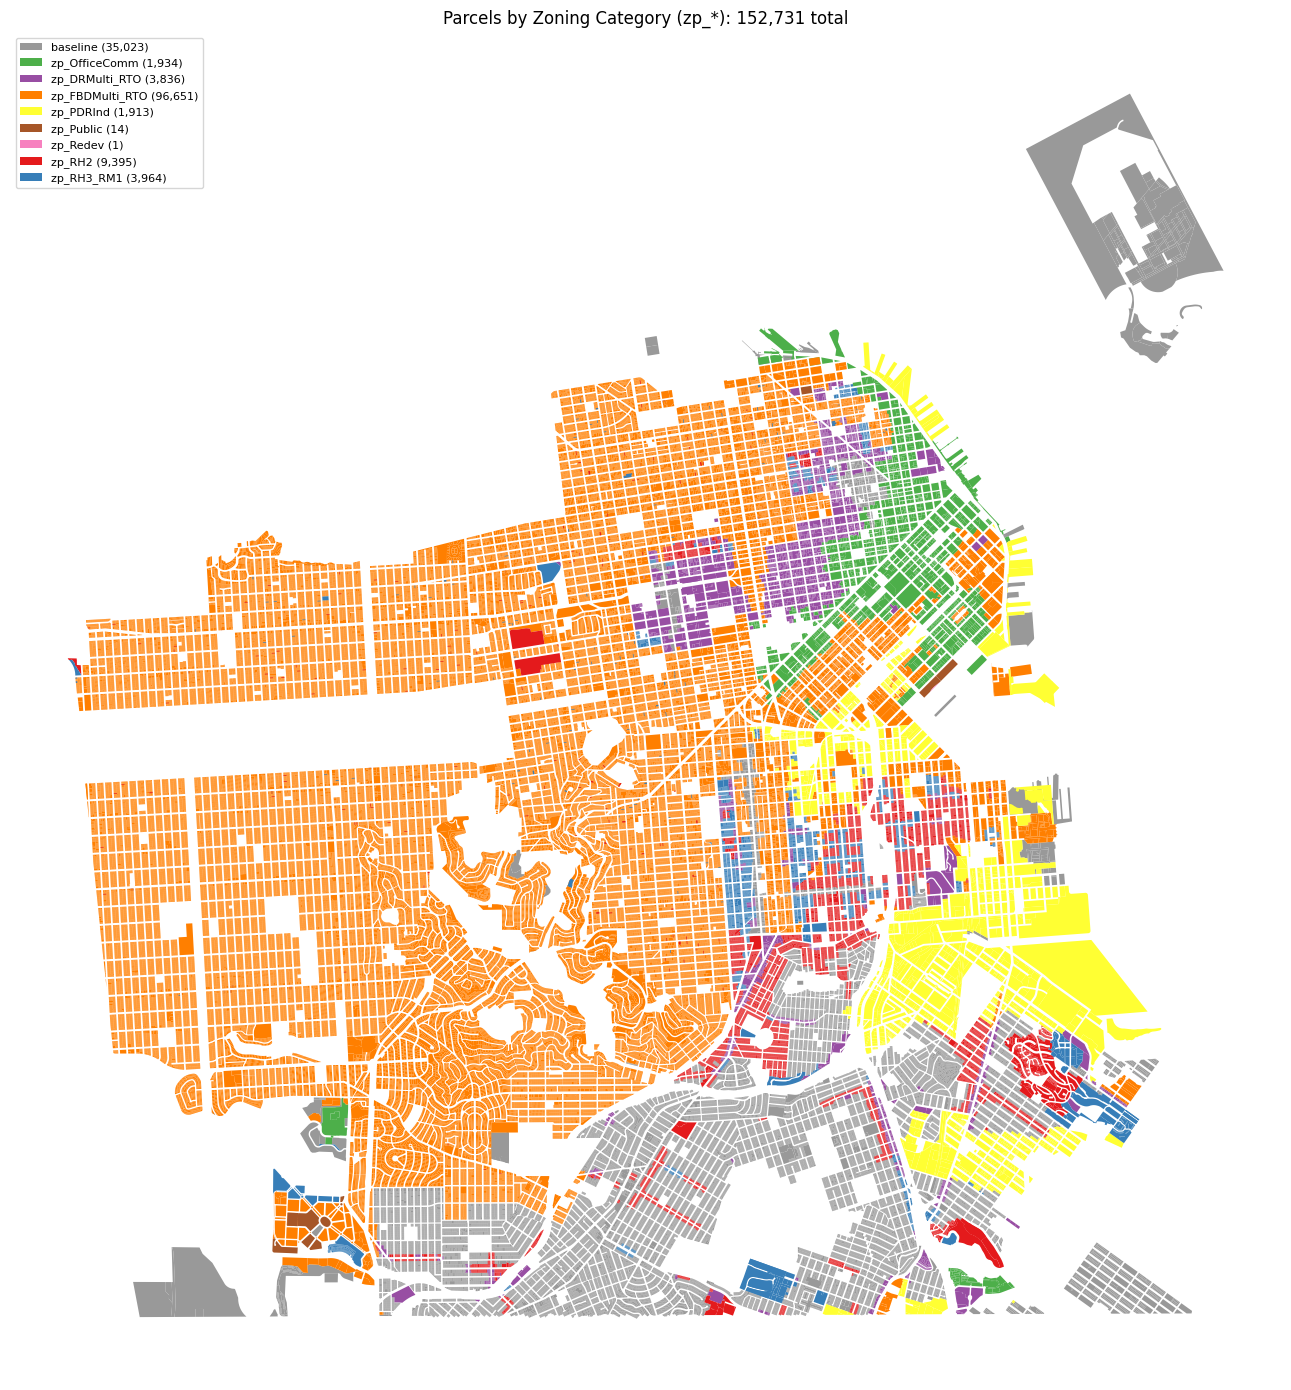

In [29]:
from matplotlib.patches import Patch
from transforms.fill_zoning import ZP_COLS

zp_cols = ZP_COLS

zp_colors = {
    'zp_RH2': '#e41a1c',
    'zp_RH3_RM1': '#377eb8',
    'zp_OfficeComm': '#4daf4a',
    'zp_DRMulti_RTO': '#984ea3',
    'zp_FBDMulti_RTO': '#ff7f00',
    'zp_PDRInd': '#ffff33',
    'zp_Public': '#a65628',
    'zp_Redev': '#f781bf',
    'baseline': '#999999',
}

geom_df = parcels_df.copy()
geom_df['geometry'] = geom_df['shape'].apply(wkt.loads)
geom_df = gpd.GeoDataFrame(geom_df, geometry='geometry', crs='EPSG:4326')

def get_zp_category(row):
    for col in zp_cols:
        if row[col] == '1':
            return col
    return 'baseline'

geom_df['zp_category'] = geom_df.apply(get_zp_category, axis=1)

category_counts = geom_df['zp_category'].value_counts()
print(f'Parcels by zoning category:')
for cat, count in category_counts.items():
    print(f'  {cat}: {count:,}')

fig, ax = plt.subplots(figsize=(14, 14))

legend_handles = []
for category in ['baseline'] + zp_cols:
    subset = geom_df[geom_df['zp_category'] == category]
    if len(subset) > 0:
        subset.plot(ax=ax, color=zp_colors[category], edgecolor='none', linewidth=0.1)
        legend_handles.append(Patch(facecolor=zp_colors[category], label=f'{category} ({len(subset):,})'))

ax.set_title(f'Parcels by Zoning Category (zp_*): {len(geom_df):,} total')
ax.legend(handles=legend_handles, loc='upper left', fontsize=8)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Fill Height_Ft from Height and Bulk Districts

For parcels missing Height_Ft, use spatial join with height-and-bulk-districts.csv to fill in the height.

In [30]:
raw_height_bulk_df = pd.read_csv('input/height-and-bulk-districts.csv', dtype=str)
raw_height_bulk_gdf = gpd.GeoDataFrame(
    raw_height_bulk_df,
    geometry=gpd.GeoSeries.from_wkt(raw_height_bulk_df['the_geom']),
    crs='EPSG:4326'
)
print(f'raw_height_bulk_gdf (height-and-bulk-districts.csv): {len(raw_height_bulk_gdf):,} rows')

missing_before = parcels_df['Height_Ft'].isna().sum()
print(f'Parcels missing Height_Ft before: {missing_before:,}')

parcels_df = fill_height_from_spatial_join(parcels_df, raw_height_bulk_gdf)

print(f'Parcels with Height_Ft after: {parcels_df["Height_Ft"].notna().sum():,}')
print(f'Parcels without Height_Ft after: {parcels_df["Height_Ft"].isna().sum():,}')

raw_height_bulk_gdf (height-and-bulk-districts.csv): 1,197 rows
Parcels missing Height_Ft before: 60,284


Parcels with Height_Ft after: 151,901
Parcels without Height_Ft after: 830


In [31]:
height_numeric = parcels_df['Height_Ft'].str.replace(',', '').astype(float)
open_space_count = (height_numeric >= 1000).sum()
print(f'Parcels with Height_Ft >= 1000 (open space): {open_space_count:,}')

if open_space_count > 0:
    print(f'Height values in these parcels:')
    print(parcels_df[height_numeric >= 1000]['Height_Ft'].value_counts())

print(f'\nBefore removing open space: {len(parcels_df):,}')

parcels_df, raw_public_parcels_df = remove_open_space_parcels(parcels_df, '../public/data/public-parcels.geojson')

print(f'After removing open space: {len(parcels_df):,}')

Parcels with Height_Ft >= 1000 (open space): 0

Before removing open space: 152,731
After removing open space: 152,731


### Remove Non-Housing Parcels

Remove parcels that are not suitable for housing development:

**Industrial/PDR zones** (M-1, M-2, PDR-1-B, PDR-1-D, PDR-1-G, PDR-2):
- Port facilities, factories, warehouses
- Not zoned for residential use

**Treasure Island zones** (TI-OS, TI-R, TI-MU):
- Under special development jurisdiction
- TI-OS is open space (34,763 expected units from 30 parcels = obviously wrong)

**Public zones** (P):
- Government buildings, parks
- Not privately developable

**Large RH-1(D) parcels** (Area > 100k sq ft):
- Golf courses (Olympic Club, SF Golf Club)
- Schools (Archbishop Riordan HS, Chinese American International School)
- Parks and open spaces
- These are incorrectly generating thousands of expected units

These parcels are moved to public-parcels.geojson for reference but excluded from housing calculations.

In [32]:
print(f'Non-housing exact zones: {NON_HOUSING_EXACT_ZONES}')

print(f'Non-housing prefix patterns: {NON_HOUSING_PREFIX_PATTERNS}')
print(f'Large parcel threshold: {LARGE_PARCEL_AREA_THRESHOLD}k sq ft')
print()

non_housing_mask = identify_non_housing_parcels(parcels_df)
print(f'Non-housing parcels identified: {non_housing_mask.sum():,}')
print()

non_housing_df = parcels_df[non_housing_mask]
print('Breakdown by zone pattern:')
for pattern in NON_HOUSING_EXACT_ZONES + NON_HOUSING_PREFIX_PATTERNS:
    mask = non_housing_df['zoning_code'].str.contains(pattern, na=False)
    if mask.sum() > 0:
        print(f'  {pattern}: {mask.sum():,} parcels')

area_numeric = pd.to_numeric(parcels_df['Area_1000'], errors='coerce').fillna(0)
large_rh1d = (parcels_df['zoning_code'] == 'RH-1(D)') & (area_numeric > LARGE_PARCEL_AREA_THRESHOLD)
if large_rh1d.sum() > 0:
    print(f'  Large RH-1(D) (>{LARGE_PARCEL_AREA_THRESHOLD}k sqft): {large_rh1d.sum():,} parcels')

print()
print(f'Before removing non-housing: {len(parcels_df):,}')
parcels_df = remove_non_housing_parcels(parcels_df, '../public/data/public-parcels.geojson')
print(f'After removing non-housing: {len(parcels_df):,}')

Non-housing exact zones: ['M-1', 'M-2', 'P']
Non-housing prefix patterns: ['PDR-1-B', 'PDR-1-D', 'PDR-1-G', 'PDR-2', 'TI-OS', 'TI-R', 'TI-MU']
Large parcel threshold: 100k sq ft

Non-housing parcels identified: 1,837

Breakdown by zone pattern:
  M-1: 83 parcels
  M-2: 54 parcels
  P: 1,566 parcels
  PDR-1-B: 106 parcels
  PDR-1-D: 57 parcels
  PDR-1-G: 477 parcels
  PDR-2: 937 parcels
  TI-OS: 115 parcels
  TI-R: 46 parcels
  TI-MU: 41 parcels
  Large RH-1(D) (>100k sqft): 18 parcels

Before removing non-housing: 152,731


After removing non-housing: 150,894


### Remove Bayview Hunters Point Shipyard Parcels

Remove 751 parcels in the Bayview Hunters Point shipyard redevelopment area that are missing both zoning and height data.

**Why these are excluded:**
- Located in the former naval shipyard, now under special redevelopment jurisdiction
- Not covered by standard SF zoning districts (`zoning-district.csv`)
- Not covered by height-and-bulk districts (`height-and-bulk-districts.csv`)
- No address data in SF Assessor records
- Development governed by separate Hunters Point Shipyard redevelopment plan

These parcels cannot be modeled using the standard FZP methodology.

In [33]:
print(f'Before removing shipyard parcels: {len(parcels_df):,}')

parcels_df = remove_shipyard_parcels(parcels_df)

print(f'After removing shipyard parcels: {len(parcels_df):,}')

Before removing shipyard parcels: 150,894
After removing shipyard parcels: 150,148


## Calculate Env_1000_Area_Height

Calculate envelope as Area_1000 * Height_Ft / 10 for parcels missing this value.

In [34]:
missing_before = parcels_df['Env_1000_Area_Height'].isna().sum()
print(f'Parcels missing Env_1000_Area_Height before: {missing_before:,}')

parcels_df = fill_envelope(parcels_df)

print(f'Parcels with Env_1000_Area_Height after: {parcels_df["Env_1000_Area_Height"].notna().sum():,}')
print(f'Parcels without Env_1000_Area_Height after: {parcels_df["Env_1000_Area_Height"].isna().sum():,}')

Parcels missing Env_1000_Area_Height before: 57,709
Parcels with Env_1000_Area_Height after: 150,148
Parcels without Env_1000_Area_Height after: 0


## Local Program vs. State Density Bonus
Due to the complexity of this program, for now, we assume state density bonus does not get used. TODO: figure out state density bonus vs. local program interaction.

## SDB (State Density Bonus) Qualification Heuristic

SDB applies to parcels that can accommodate 5+ units. Based on analysis of FZP model data, we derived a heuristic with 99.93% accuracy:

**SDB = 1 if ALL of:**
1. Zoning code contains "RTO", "NCT", or "WMUG"
2. Envelope (`Env_1000_Area_Height`) > 9.0
3. Height ≤ 130 ft

Validation against FZP data (92,722 parcels):
- True positives: 8,308 (correctly identified SDB)
- True negatives: 84,349 (correctly identified non-SDB)
- False positives: 31 (over-predicted)
- False negatives: 34 (missed)
- Precision: 99.6%, Recall: 99.6%

For east-side parcels missing SDB data, we apply this heuristic to compute `SDB_2016_5Plus`.

In [35]:
sdb_cols = ['SDB_2016_5Plus', 'SDB_2016_5Plus_EnvFull', 'Zoning_DR_EnvFull']
print('Before filling SDB columns:')
for col in sdb_cols:
    missing = (parcels_df[col].isna() | (parcels_df[col] == '')).sum()
    print(f'  {col} missing: {missing:,}')

parcels_df = fill_sdb_columns(parcels_df)

print('\nAfter filling SDB columns (all missing values set to 0)')

Before filling SDB columns:
  SDB_2016_5Plus missing: 57,709
  SDB_2016_5Plus_EnvFull missing: 57,709
  Zoning_DR_EnvFull missing: 57,709



After filling SDB columns (all missing values set to 0)


## Historic Status from Historic Districts

Use historic-districts.csv to determine whether a parcel is in a historic district.
Perform spatial join using parcel centroids and compare against the existing `historic` column from FZP model data.

The outcome isn't very good. about 11k false positives (marked as historic but should not have been). Still I don't know of a better way to do it. TODO figure out more correct way to determine if a parcel is historic.

In [36]:
raw_historic_districts_df = pd.read_csv('input/historic-districts.csv', dtype=str)
raw_historic_districts_gdf = gpd.GeoDataFrame(
    raw_historic_districts_df,
    geometry=gpd.GeoSeries.from_wkt(raw_historic_districts_df['the_geom']),
    crs='EPSG:4326'
)

parcels_df = compute_historic_from_districts(parcels_df, raw_historic_districts_gdf)

in_historic = (parcels_df['in_historic_district'] == '1').sum()
print(f'Parcels in historic districts: {in_historic:,}')

# Compare with existing historic column from FZP
has_historic = parcels_df['historic'].notna() & (parcels_df['historic'] != '')
comparison_df = parcels_df[has_historic].copy()
print(f'\nParcels with historic column from FZP: {len(comparison_df):,}')

comparison_df['fzp_historic'] = comparison_df['historic'].astype(int)
comparison_df['computed_historic'] = comparison_df['in_historic_district'].astype(int)

match = comparison_df['fzp_historic'] == comparison_df['computed_historic']
print(f'Match rate: {match.mean()*100:.2f}%')

Parcels in historic districts: 17,874

Parcels with historic column from FZP: 92,436
Match rate: 87.56%


In [37]:
missing_before = ((parcels_df['historic'].isna() | (parcels_df['historic'] == '')) & 
                  (parcels_df['Historic'].isna() | (parcels_df['Historic'] == ''))).sum()
print(f'Parcels missing historic before: {missing_before:,}')

parcels_df = fill_historic_columns(parcels_df)

print(f'Filled historic for {missing_before:,} parcels')

Parcels missing historic before: 57,709


Filled historic for 57,709 parcels


## Pre-calculate Calculate Expected Units under FZP

Pre-compute expected units at FZP heights using the City Economist's model.

In [38]:
parcels_df = calculate_expected_units(parcels_df)

print(f"Total expected units (low): {parcels_df['fzp_expected_units_low'].sum():,.0f}")
print(f"Total expected units (high): {parcels_df['fzp_expected_units_high'].sum():,.0f}")

Total expected units (low): 29,148
Total expected units (high): 48,192


In [39]:
# Debug: List parcels with expected units breakdown, sorted by highest expected value
debug_df = parcels_df[['mapblklot', 'Height_Ft', 'Area_1000', 'Env_1000_Area_Height', 'SDB_2016_5Plus_EnvFull', 'Zoning_DR_EnvFull', 'fzp_expected_units_low', 'fzp_expected_units_high']].copy()

# Sort by highest expected units (high scenario)
debug_df_sorted = debug_df.sort_values('fzp_expected_units_high', ascending=False)

print(f"Top 50 parcels by expected units (high scenario):")
print(debug_df_sorted.head(50).to_string())

print(f"\n\nSummary statistics:")
print(f"Total parcels: {len(debug_df):,}")
print(f"Parcels with expected_high > 1: {(debug_df['fzp_expected_units_high'] > 1).sum():,}")
print(f"Parcels with expected_high > 10: {(debug_df['fzp_expected_units_high'] > 10).sum():,}")
print(f"Max expected_high: {debug_df['fzp_expected_units_high'].max():,.1f}")
print(f"Mean expected_high: {debug_df['fzp_expected_units_high'].mean():.4f}")

Top 50 parcels by expected units (high scenario):
       mapblklot Height_Ft           Area_1000 Env_1000_Area_Height SDB_2016_5Plus_EnvFull Zoning_DR_EnvFull  fzp_expected_units_low  fzp_expected_units_high
32899    3734091       340   459.4844114482084   15622.469989239084                    0.0                 0             6570.406956              6641.017973
23517    3723115       340   329.9963422841497   11219.875637661089                    0.0                 0             3288.672816              4314.176340
130946   1094001       350               298.5              10446.4                    0.0               0.0             1886.502234              3010.265770
121193   7295038        65   958.2671092775983    6228.736210304389                    0.0                 0             1585.198281              2230.747869
116952  8719A006        90   401.6281307460729    3614.653176714656                    0.0                 0              597.049854               976.744285
46

## Final Checkup

### Empty Colums Remaining

In [40]:
# EMPTY COLUMN COUNTS
empty_counts = parcels_df.isna().sum() + (parcels_df == '').sum()
print(f'parcels_df: {len(parcels_df):,} rows, {len(parcels_df.columns)} columns\n')
print(f'{"Column":<40} {"Empty":>10}')
print('-' * 52)
for col in parcels_df.columns:
    count = empty_counts[col]
    print(f'{col:<40} {count:>10,}')

parcels_df: 150,148 rows, 75 columns

Column                                        Empty
----------------------------------------------------
mapblklot                                         0
blklots                                           0
from_address_num                              1,515
to_address_num                                1,611
street_name                                   1,515
street_type                                   2,505
odd_even                                      1,611
in_asr_secured_roll                               0
pw_recorded_map                                   0
zoning_code                                       7
zoning_district                                   7
date_rec_add                                135,219
date_rec_drop                               149,558
date_map_add                                     41
date_map_drop                               150,096
date_map_alt                                149,979
project_id_add           

TODO: Investigate:
- 830 missing FZP Planning Code and Height_Ft
- 717 missing Tot_Existing_Sqft & Bldg_SqFt_1000
- 754 missing Planning Code & Planning District

## Write Out

In [41]:
from shapely import wkt
import os

os.makedirs('output', exist_ok=True)

overlay_cols = [
    'mapblklot',
    'from_address_num',
    'street_name',
    'street_type',
    'analysis_neighborhood',
    'zoning_code',
    'zoning_district',
    'supervisor_district',
    'supname',
    'Height_Ft',
    'distance_to_transit',
]

model_cols = [
    'mapblklot',
    'Height_Ft',
    'Area_1000',
    'Env_1000_Area_Height',
    'Bldg_SqFt_1000',
    'Res_Dummy',
    'Historic',
    'SDB_2016_5Plus',
    'zp_OfficeComm',
    'zp_DRMulti_RTO',
    'zp_FBDMulti_RTO',
    'zp_PDRInd',
    'zp_Public',
    'zp_Redev',
    'zp_RH2',
    'zp_RH3_RM1',
    'DIST_SBayshore',
    'DIST_BernalHts',
    'DIST_Scentral',
    'DIST_Central',
    'DIST_BuenaVista',
    'DIST_Northeast',
    'DIST_WestAddition',
    'DIST_SOMA',
    'DIST_InnerSunset',
    'DIST_Richmond',
    'DIST_Ingleside',
    'DIST_OuterSunset',
    'DIST_Marina',
    'DIST_Mission',
    'SDB_2016_5Plus_EnvFull',
    'Zoning_DR_EnvFull',
    'fzp_expected_units_low',
    'fzp_expected_units_high',
]

geom_gdf = gpd.GeoDataFrame(
    parcels_df[['mapblklot']],
    geometry=parcels_df['shape'].apply(wkt.loads),
    crs='EPSG:4326'
)

print('Calculating transit distances...')
geom_gdf = fill_transit_distance(
    geom_gdf,
    '../public/data/transit-bart.geojson',
    '../public/data/transit-muni.geojson',
    '../public/data/transit-caltrain.geojson'
)
parcels_df['distance_to_transit'] = geom_gdf['distance_to_transit'].values
print(f'Calculated transit distances for {len(geom_gdf):,} parcels')

geom_gdf = geom_gdf.drop(columns=['distance_to_transit'])
geom_gdf.to_file('output/parcels.geojson', driver='GeoJSON')
print(f'Wrote output/parcels.geojson ({len(geom_gdf):,} features)')

overlay_df = parcels_df[overlay_cols].copy()
overlay_df.to_csv('output/parcels-overlay.csv', index=False)
print(f'Wrote output/parcels-overlay.csv ({len(overlay_df):,} rows, {len(overlay_cols)} columns)')

model_df = parcels_df[model_cols].copy()
model_df = model_df.rename(columns={'mapblklot': 'BlockLot'})
model_df.to_csv('output/parcels-model.csv', index=False)
print(f'Wrote output/parcels-model.csv ({len(model_df):,} rows, {len(model_cols)} columns)')

Calculating transit distances...


Calculated transit distances for 150,148 parcels


Wrote output/parcels.geojson (150,148 features)


Wrote output/parcels-overlay.csv (150,148 rows, 11 columns)


Wrote output/parcels-model.csv (150,148 rows, 34 columns)


## Copy to Public Data


In [ ]:
# Enrich public parcels with overlay data (address, neighborhood, supervisor)
from transforms import enrich_public_parcels

enrich_public_parcels("../public/data/public-parcels.geojson", raw_parcels_df)
print("Enriched public parcels with overlay data")


In [42]:
import shutil

shutil.copy('output/parcels.geojson', '../public/data/parcels.geojson')
shutil.copy('output/parcels-overlay.csv', '../public/data/parcels-overlay.csv')
shutil.copy('output/parcels-model.csv', '../public/data/parcels-model.csv')
print('Copied output files to ../public/data/')

Copied output files to ../public/data/
